
## Queueing Stochastic Game Framework — Cooperative vs. Non-Cooperative Analysis

This notebook implements and analyzes a **two-player stochastic game** that captures interactions between wireless transmitters sharing a common channel with queueing dynamics.  
Each player maintains its own buffer and decides whether to transmit based on **channel quality** and **queue occupancy**.  
The system is modeled as a discrete-time Markov decision process (MDP) with coupled payoffs due to interference.

Three cost formulations are supported:

1. **`ZEROSUM`** — adversarial interaction where one player’s gain equals the other’s loss.  
2. **`DECENTRNONCOOP`** — decentralized non-cooperative game; each player maximizes its own throughput under an average power constraint.  
3. **`DECENTRCOOP`** —   team problem (still decentralized) game; both players jointly maximize the overall system throughput.

The notebook proceeds as follows:
- Define the model parameters and core LP solvers for queue dynamics and best-response computation.  
- Compute equilibria for non-cooperative and cooperative cases.  
- Compare the resulting throughputs, power allocations, and policies.  

This framework provides a foundation for studying **coordination, interference management, and efficiency losses** due to selfish behavior in queue-coupled wireless systems.


For further reference, see Section IV-B-1 and IV-B-2 of

Altman, E., Avratchenkov, K., Bonneau, N., Debbah, M., El-Azouzi, R., & Menasché, D. S. (2007, November). Constrained stochastic games in wireless networks. In IEEE GLOBECOM 2007-IEEE Global Telecommunications Conference (pp. 315-320). IEEE.

Actually, the numbers produced here are those reported in the paper. This is a reproducibility package for the paper.

### Core Model Definition

This cell defines the core data structures and linear programming routines used throughout the queueing stochastic game.  
It introduces the `Settings` dataclass for configuring system parameters (e.g., number of link states, buffer levels, power actions, admission actions, and power limits),  
and provides two main functions:

- **`queuedefs(s)`** — builds the model matrices for queue and channel transitions, defines cost functions (`c1`, `c2`) according to the selected mode (`ZEROSUM`, `DECENTRCOOP`, or `DECENTRNONCOOP`), and returns all derived constants needed for optimization.
- **`queuestr_lp(for_player, rho_other, defs)`** — solves the linear program representing one player’s best response given the other’s occupation measure `rho_other`.

Together, these functions form the foundation of the cooperative and non-cooperative solution procedures implemented later.


### Definição do Modelo e Matrizes de Payoff

Esta função `queuedefs()` define o modelo completo do jogo estocástico:
- **Parâmetros do sistema**: estados de canal (NS), tamanhos de buffer (NB), ações de potência (NA) e admissão (NB_adm)
- **Transições de canal**: Markov chain (PL) modelando qualidade do canal
- **Transições de fila**: matriz P modelando dinâmica do buffer (chegadas/saídas)

**Matrizes c1 e c2 - Funções de Payoff:**  
Representam a taxa de transmissão (throughput) de cada jogador baseada no SINR (Signal-to-Interference-plus-Noise Ratio). Mudam conforme o modo:

- **Zero-Sum** (adversarial): 
  - c1[i,a,j,b] = log₂(1 + SINR₁) 
  - c2[i,a,j,b] = -c1 (ganho de um é perda do outro)

- **Non-Cooperative** (Nash): 
  - c1[i,a,j,b] = log₂(1 + SINR₁) 
  - c2[i,a,j,b] = log₂(1 + SINR₂) (cada um maximiza seu próprio throughput)

- **Cooperative** (Team): 
  - c1 = c2 = log₂(1 + SINR₁) + log₂(1 + SINR₂) (maximizam throughput agregado)

### Solução via Programação Linear (Best-Response)

A função `queuestr_lp()` resolve o problema de um jogador contra a estratégia fixa do oponente:
- **Entrada**: estratégia (occupation measure) do oponente
- **Objetivo**: maximizar throughput esperado do jogador
- **Restrições**: 
  - Equações de balanço de fluxo (flow-balance)
  - Limite de potência média (v1 ou v2)
  - Admissão válida apenas com buffer não-vazio
- **Saída**: occupation measure ótima ρ (probabilidade de estado-ação)

In [8]:
import numpy as np
from dataclasses import dataclass
from scipy.optimize import linprog

ZEROSUM        = 1
DECENTRCOOP    = 2
DECENTRNONCOOP = 3

@dataclass
class Settings:
    NLinkStates: int
    NBufferStates: int
    NPowActs: int
    NAdmContrActs: int
    ArrProb: float
    v1: float
    v2: float
    rho1: any = np.nan
    rho2: any = np.nan
    CostFunction: int = DECENTRNONCOOP


def queuedefs(s: Settings):
    NS, NB, NA, NB_adm = s.NLinkStates, s.NBufferStates, s.NPowActs, s.NAdmContrActs
    arr_prob, v1, v2, cost_mode = s.ArrProb, s.v1, s.v2, s.CostFunction

    # Channel transition (reflecting random walk)
    PL = np.zeros((NS, NS))
    for j in range(NS):
        if j == 0:
            PL[j, j] = 0.5; PL[j, j+1] = 0.5
        elif j == NS-1:
            PL[j, j] = 0.5; PL[j, j-1] = 0.5
        else:
            PL[j, j-1:j+2] = [1/3, 1/3, 1/3]

    # Steady-state distribution
    P1 = PL.T - np.eye(NS)
    P1 = np.vstack([P1[:-1, :], np.ones((1, NS))])
    e1 = np.zeros(NS); e1[-1] = 1
    pi = np.linalg.solve(P1, e1)

    def queuepos1(i,j,a,b):
        return (((i)*NB + j)*NA + a)*NB_adm + b

    # Queue transitions: P[j,a,b,new_j]
    P = np.zeros((NB, NA, NB_adm, NB))
    for j in range(NB):
        for a in range(NA):
            for b in range(NB_adm):
                served = min(j, 1) if a != 0 else 0
                new_sz_arr = min(j - served + b, NB-1)
                new_sz_no  = j - served
                P[j,a,b,new_sz_arr] += arr_prob
                P[j,a,b,new_sz_no ] += (1 - arr_prob)

    # Channel qualities
    Nu = np.linspace(0.0, 1.0, NS)
    N0, s_coeff = 1.0, 1.0

    # Cost matrices
    c1 = np.zeros((NS, NA, NS, NA))
    c2 = np.zeros_like(c1)
    for x in range(NS):
        for a in range(1, NA + 1):
            for y in range(NS):
                for b in range(1, NA + 1):
                    SINR1 = ((a - 1) * Nu[x]) / (N0 + s_coeff * (b - 1) * Nu[y])
                    SINR2 = ((b - 1) * Nu[y]) / (N0 + s_coeff * (a - 1) * Nu[x])
                    SINR1, SINR2 = max(SINR1, 0.0), max(SINR2, 0.0)
                    if cost_mode == ZEROSUM:
                        c1[x,a-1,y,b-1] = np.log2(1.0 + SINR1)
                        c2[x,a-1,y,b-1] = -c1[x,a-1,y,b-1]
                    elif cost_mode == DECENTRCOOP:
                        tot = np.log2(1.0 + SINR1) + np.log2(1.0 + SINR2)
                        c1[x,a-1,y,b-1] = tot
                        c2[x,a-1,y,b-1] = tot
                    else:  # DECENTRNONCOOP
                        c1[x,a-1,y,b-1] = np.log2(1.0 + SINR1)
                        c2[x,a-1,y,b-1] = np.log2(1.0 + SINR2)

    d1 = np.arange(NA, dtype=float).reshape(1, -1)
    d2 = d1.copy()

    return dict(NS=NS, NB=NB, NA=NA, NB_adm=NB_adm,
                PL=PL, P=P, Nu=Nu, N0=N0, s_coeff=s_coeff,
                c1=c1, c2=c2, d1=d1, d2=d2, steadystate_pi=pi,
                NStates=NS*NB*NA*NB_adm, queuepos1=queuepos1,
                v1=v1, v2=v2, CostFunction=cost_mode)






### Algoritmo Iterativo de Best-Response

A função `queuesolvegame_py()` encontra o equilíbrio (Nash ou Team) iterativamente:
1. **Inicialização**: política heurística ou uniforme para ambos jogadores
2. **Iteração**: cada jogador calcula best-response contra estratégia atual do outro
3. **Convergência**: para quando valores (val1, val2) estabilizam (ε < 10⁻¹⁰)
4. **Resultado**: equilíbrio de Nash (non-coop) ou solução de time (coop)

**Nota:** Corrigimos um bug de propagação do `CostFunction`; agora o best-response respeita corretamente os modos Zero-Sum, Non-Coop e Cooperative.


### Funções Auxiliares

- **`extract_policy()`**: extrai política de potência dominante de cada estado
- **`extract_admission_policy()`**: extrai política de admissão dominante
- **`plot_policies()`**: visualiza políticas como heatmaps (link state × buffer state)
- **`evaluate_physical_throughput()`**: calcula throughput real (físico) baseado em SINR, independente da função objetivo do jogo

## Experimentos: Comparação dos Três Modos de Jogo

Executamos o modelo com parâmetros idênticos em três configurações:
1. **Zero-Sum**: jogo adversarial (conflito total)
2. **Non-Cooperative**: equilíbrio de Nash (cada um por si)
3. **Cooperative**: problema de time (cooperação total)

Para cada modo, calculamos políticas ótimas de potência e admissão, e avaliamos o throughput físico agregado.

In [9]:
def queuestr_lp(for_player: int, rho_other: np.ndarray, defs: dict):
    """
    Best-response LP for one player against opponent's occupation measure.

      - if both queues non-empty:   use payoff(i,a,k,d)
      - if j==0, l>0:               freeze player-1 power -> a := 0
      - if j>0, l==0:               freeze player-2 power -> d := 0
      - if j==0, l==0:              contributes nothing

    In DECENTRCOOP, maximize sum-rate (c1+c2). In DECENTRNONCOOP/ZEROSUM, each
    player uses its own payoff tensor (c1 for player 1, c2 for player 2).
    """
    NS, NB, NA, NB_adm = defs['NS'], defs['NB'], defs['NA'], defs['NB_adm']
    c1, c2, d1, d2 = defs['c1'], defs['c2'], defs['d1'], defs['d2']
    v1, v2 = defs['v1'], defs['v2']
    PL, Pq = defs['PL'], defs['P']
    queuepos1 = defs['queuepos1']
    cost_mode = defs.get('CostFunction', DECENTRNONCOOP)

    NVars = NS * NB * NA * NB_adm
    f = np.zeros(NVars, dtype=float)

    # ----- Objective: case logic without "served" multiplier -----
    # For DECENTRCOOP we maximize sum-rate; in this port c1==c2==sum-rate,
    # but we keep it explicit for clarity.
    for i in range(NS):
        for j in range(NB):
            for a in range(NA):
                for b in range(NB_adm):
                    acc = 0.0
                    for k in range(NS):
                        for l in range(NB):
                            # mass over opponent's power (sum over their admission dim)
                            mass2_over_d = np.sum(rho_other[k, l, :, :], axis=-1)  # shape [NA]
                            if mass2_over_d.size == 0 or np.allclose(mass2_over_d.sum(), 0.0):
                                continue

                            if cost_mode == DECENTRCOOP:
                                # Sum-rate objective (use c1+c2; here c1 already stores sum in defs)
                                for d in range(NA):
                                    if (l > 0) and (j > 0):
                                        acc += c1[i, a, k, d] * mass2_over_d[d]
                                    elif (l > 0) and (j == 0):
                                        acc += c1[i, 0, k, d] * mass2_over_d[d]
                                    elif (j > 0) and (l == 0):
                                        acc += c1[i, a, k, 0] * mass2_over_d[d]
                                    # both empty -> no contribution
                            else:
                                # --- Non-cooperative: each player uses its own payoff tensor ---
                                    for d in range(NA):
                                        if for_player == 1:
                                            if (l > 0) and (j > 0):
                                                acc += c1[i, a, k, d] * mass2_over_d[d]
                                            elif (l > 0) and (j == 0):
                                                acc += c1[i, 0, k, d] * mass2_over_d[d]
                                            elif (j > 0) and (l == 0):
                                                acc += c1[i, a, k, 0] * mass2_over_d[d]
                                            # else both empty → no contribution
                                        else:  # player 2
                                            if (l > 0) and (j > 0):
                                                acc += c2[k, d, i, a] * mass2_over_d[d]
                                            elif (l > 0) and (j == 0):
                                                acc += c2[k, d, i, 0] * mass2_over_d[d]
                                            elif (j > 0) and (l == 0):
                                                acc += c2[k, 0, i, a] * mass2_over_d[d]


                    f[queuepos1(i, j, a, b)] = acc

    fmax = np.max(np.abs(f))
    if fmax > 0:
        f /= fmax
    else:
        raise RuntimeError("Objective vector is all zeros; check payoffs and masks.")

    # ----- Bounds: forbid reject when buffer empty and forbid transmit when empty -----
    bounds = []
    for i in range(NS):
        for j in range(NB):
            for a in range(NA):
                for b in range(NB_adm):
                    ub = 1.0
                    if j == 0 and (b == 0 or a > 0):
                        ub = 0.0
                    bounds.append((0.0, ub))

    # ----- Flow-balance constraints over states s=(i,j) -----
    n_states = NS * NB
    Aeq_flow = np.zeros((n_states, NVars))
    beq_flow = np.zeros(n_states)

    def sidx(ii, jj): return ii * NB + jj

    # Outgoing mass
    for i in range(NS):
        for j in range(NB):
            row = sidx(i, j)
            for a in range(NA):
                for b in range(NB_adm):
                    Aeq_flow[row, queuepos1(i, j, a, b)] += 1.0

    # Incoming mass via (ip,jp,ap,bp) -> (i,j) transitions
    for ip in range(NS):
        for jp in range(NB):
            for ap in range(NA):
                for bp in range(NB_adm):
                    colp = queuepos1(ip, jp, ap, bp)
                    for i in range(NS):
                        pij_link = PL[ip, i]
                        if pij_link == 0.0:
                            continue
                        for j in range(NB):
                            pij_queue = Pq[jp, ap, bp, j]
                            if pij_queue == 0.0:
                                continue
                            row = sidx(i, j)
                            Aeq_flow[row, colp] -= pij_link * pij_queue

    # Normalization
    Aeq = np.vstack([Aeq_flow, np.ones((1, NVars))])
    beq = np.concatenate([beq_flow, [1.0]])

    # ----- Power constraint (per player) -----
    vlim, dvec = (v1, d1[0]) if for_player == 1 else (v2, d2[0])
    A_ub = np.zeros((1, NVars))
    idx = 0
    for i in range(NS):
        for j in range(NB):
            for a in range(NA):
                for b in range(NB_adm):
                    A_ub[0, idx] = dvec[a]
                    idx += 1
    b_ub = np.array([vlim])

    # ----- Solve LP (maximize via minimize) -----
    res = linprog(c=-f, A_ub=A_ub, b_ub=b_ub, A_eq=Aeq, b_eq=beq,
                  bounds=bounds, method="highs")
    if not res.success:
        raise RuntimeError(f"LP failed for player {for_player}: {res.message}")

    x = res.x
    val = -res.fun
    rho = x.reshape(NS, NB, NA, NB_adm)
    constr_val = np.sum(rho * dvec.reshape(1, 1, -1, 1))
    print(f"[Player {for_player}] val={val:.6f}, power={constr_val:.6f} (limit={vlim:.6f})")
    return rho, val, constr_val


### Iterative Solver for Decentralized Equilibrium — `queuesolvegame_py`

This function implements the **iterative best-response algorithm** used to compute a Nash equilibrium for the decentralized (non-cooperative) stochastic game.  
Each player alternately solves a linear program representing its **best response** to the current policy of the other player, under average power constraints.

**Algorithm overview:**
1. **Initialization:**  
   - If `init_policy_guess=True`, each player starts from a structured “policy-based” guess that roughly follows intuitive transmission rules.  
   - Otherwise, both players start from a uniform random policy across all feasible actions.

2. **Iterative updates:**  
   - At each iteration, Player 1 optimizes its occupation measure `ρ₁` given Player 2’s current strategy `ρ₂`, and vice versa.  
   - The process continues until the values (`val₁`, `val₂`) converge below a tolerance threshold (`ε = 1e-10`).

3. **Output:**  
   Returns the steady-state equilibrium values and the corresponding joint occupation measures:
   \[
   (\text{val}_1, \text{val}_2, \rho_1, \rho_2)
   \]
   where `ρ₁` and `ρ₂` encode the probability of each state–action combination under equilibrium.

This solver is the workhorse for finding decentralized equilibria.


In [10]:
def make_initial_guess_policy(NS, NB, NA, NB_adm):
    """
    Create a prior (initial guess) for ρ[i,j,a,b] based on heuristic equilibrium rules.
    - i: link state ∈ {0,...,NS-1}
    - j: buffer state ∈ {0,...,NB-1}
    - a: power action ∈ {0,...,NA-1}
    - b: admission action ∈ {0,1} (0=reject, 1=accept)
    """
    rho = np.zeros((NS, NB, NA, NB_adm))

    for i in range(NS):  # channel
        for j in range(NB):  # buffer
            # default: reject = 0. accept only if we transmit
            for b in range(NB_adm):
                for a in range(NA):
                    # --- Rule 1: buffer empty -> don't care (uniform) ---
                    if j == 0:
                        rho[i, j, a, b] = 1.0

                    # --- Rule 2: buffer 1-2, transmit only if channel=3 ---
                    elif j in [1, 2]:
                        if i == 3 and a > 0 and b == 1:
                            rho[i, j, a, b] = 1.0
                        else:
                            rho[i, j, a, b] = 0.1  # small mass on idle

                    # --- Rule 3: buffer 3–6, transmit if channel=2 or 3 ---
                    elif j in [3, 4, 5, 6]:
                        if i in [2, 3] and a > 0 and b == 1:
                            rho[i, j, a, b] = 1.0
                        else:
                            rho[i, j, a, b] = 0.1

                    # --- Rule 4: buffer=7, transmit at max power if ch=2 or 3 ---
                    elif j == 7:
                        if i in [2, 3] and a == NA - 1 and b == 1:
                            rho[i, j, a, b] = 1.0
                        else:
                            rho[i, j, a, b] = 0.05

    # Normalize to form a probability distribution
    rho /= np.sum(rho)
    return rho


def queuesolvegame_py(s: Settings, init_policy_guess=True):
    defs = queuedefs(s)
    NS, NB, NA, NB_adm = defs['NS'], defs['NB'], defs['NA'], defs['NB_adm']

    if init_policy_guess:
        rho1 = make_initial_guess_policy(NS, NB, NA, NB_adm)
        rho2 = make_initial_guess_policy(NS, NB, NA, NB_adm)
        print("[Init] Using policy-based equilibrium guess.")
    else:
        rho1 = np.ones((NS, NB, NA, NB_adm)) / (NS * NB * NA * NB_adm)
        rho2 = np.copy(rho1)
        print("[Init] Using uniform equilibrium guess.")

    max_it, eps = 30, 1e-10
    val1_prev = val2_prev = 0.0

    for it in range(1, max_it + 1):
        rho1, val1, _ = queuestr_lp(1, rho2, defs)
        rho2, val2, _ = queuestr_lp(2, rho1, defs)
        print(f"[Iter {it}] val1={val1:.6f}, val2={val2:.6f}, Δ1={abs(val1 - val1_prev):.3e}, Δ2={abs(val2 - val2_prev):.3e}")
        if abs(val1 - val1_prev) < eps and abs(val2 - val2_prev) < eps:
            break
        val1_prev, val2_prev = val1, val2

    return val1, val2, rho1, rho2


In [11]:
# === Basic setup: shared definitions and helper functions ===
import numpy as np
import matplotlib.pyplot as plt

v1l = 2.0
common_kwargs = dict(NLinkStates=4, NBufferStates=8, NPowActs=6, NAdmContrActs=2, ArrProb=0.5, v1=v1l, v2=v1l)

def describe_model(s):
    print("=== Model Configuration ===")
    print(f"Number of channel (link) states: {s.NLinkStates}")
    print(f"Number of buffer states:         {s.NBufferStates}")
    print(f"Number of power control actions: {s.NPowActs}")
    print(f"Number of admission actions:     {s.NAdmContrActs}")
    print(f"Arrival probability:             {s.ArrProb}")
    print(f"v1 (Player 1 power limit):       {s.v1}")
    print(f"v2 (Player 2 power limit):       {s.v2}")
    print("========================================\n")

def extract_policy(rho, NS, NB, NA, NAdm):
    policy = np.zeros((NS, NB), dtype=int)
    for i in range(NS):
        for j in range(NB):
            power_dist = np.sum(rho[i, j, :, :], axis=1)
            policy[i, j] = np.argmax(power_dist)
    return policy

def extract_admission_policy(rho, NS, NB, NA, NAdm):
    policy = np.zeros((NS, NB), dtype=int)
    for i in range(NS):
        for j in range(NB):
            adm_dist = np.sum(rho[i, j, :, :], axis=0)
            policy[i, j] = np.argmax(adm_dist)
    return policy

def plot_policies(s, policy1, policy2, adm_policy1, adm_policy2, title_prefix=""):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    im1 = ax[0].imshow(policy1, origin='lower', cmap='viridis')
    im2 = ax[1].imshow(policy2, origin='lower', cmap='viridis')
    ax[0].set_title(f"{title_prefix} Power – Player 1")
    ax[1].set_title(f"{title_prefix} Power – Player 2")
    for a in ax:
        a.set_xlabel("Buffer state"); a.set_ylabel("Link state")
        a.set_xticks(range(s.NBufferStates)); a.set_yticks(range(s.NLinkStates))
    fig.colorbar(im1, ax=ax[0]); fig.colorbar(im2, ax=ax[1])
    plt.tight_layout(); plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    im1 = ax[0].imshow(adm_policy1, origin='lower', cmap='coolwarm')
    im2 = ax[1].imshow(adm_policy2, origin='lower', cmap='coolwarm')
    ax[0].set_title(f"{title_prefix} Admission – Player 1")
    ax[1].set_title(f"{title_prefix} Admission – Player 2")
    for a in ax:
        a.set_xlabel("Buffer state"); a.set_ylabel("Link state")
        a.set_xticks(range(s.NBufferStates)); a.set_yticks(range(s.NLinkStates))
    fig.colorbar(im1, ax=ax[0]); fig.colorbar(im2, ax=ax[1])
    plt.tight_layout(); plt.show()




# === Utility: Evaluate true physical throughput (rate expectation) ===

def evaluate_physical_throughput(rho1, rho2, defs):
    """
    Compute physical-layer throughput (sum_rate, r1, r2) by integrating
    log2(1 + SINR) over the occupation measures of both players.
    Ignores CostFunction scaling and directly uses physics.
    """
    NS, NB, NA, NB_adm = defs['NS'], defs['NB'], defs['NA'], defs['NB_adm']
    Nu, N0, s_coeff = defs['Nu'], defs['N0'], defs['s_coeff']

    # Normalize occupation measures
    rho1 = rho1 / rho1.sum()
    rho2 = rho2 / rho2.sum()

    r1 = 0.0
    r2 = 0.0

    def rates(i, a, k, d):
        num1 = a * Nu[i]
        num2 = d * Nu[k]
        den1 = N0 + s_coeff * d * Nu[k]
        den2 = N0 + s_coeff * a * Nu[i]
        R1 = 0.0 if den1 <= 0 else np.log2(1.0 + num1 / den1)
        R2 = 0.0 if den2 <= 0 else np.log2(1.0 + num2 / den2)
        return R1, R2

    for i in range(NS):      # player 1 link
        for j in range(NB):  # player 1 buffer
            for a in range(NA):
                mass1 = rho1[i, j, a, :].sum()
                if mass1 == 0:
                    continue
                for k in range(NS):      # player 2 link
                    for l in range(NB):  # player 2 buffer
                        mass2_p = rho2[k, l, :, :].sum(axis=1)
                        if mass2_p.sum() == 0:
                            continue

                        # Case logic: who actually transmits
                        if (j > 0) and (l > 0):
                            for d in range(NA):
                                R1, R2 = rates(i, a, k, d)
                                r1 += R1 * mass1 * mass2_p[d]
                                r2 += R2 * mass1 * mass2_p[d]
                        elif (j == 0) and (l > 0):
                            for d in range(NA):
                                _, R2 = rates(i, 0, k, d)
                                r2 += R2 * mass1 * mass2_p[d]
                        elif (j > 0) and (l == 0):
                            R1, _ = rates(i, a, k, 0)
                            r1 += R1 * mass1 * mass2_p.sum()

    return r1 + r2, r1, r2



=== Model Configuration ===
Number of channel (link) states: 4
Number of buffer states:         8
Number of power control actions: 6
Number of admission actions:     2
Arrival probability:             0.5
v1 (Player 1 power limit):       2.0
v2 (Player 2 power limit):       2.0

[Init] Using policy-based equilibrium guess.
[Player 1] val=0.360497, power=2.000000 (limit=2.000000)
[Player 2] val=-0.727816, power=2.000000 (limit=2.000000)
[Iter 1] val1=0.360497, val2=-0.727816, Δ1=3.605e-01, Δ2=7.278e-01
[Player 1] val=0.360528, power=2.000000 (limit=2.000000)
[Player 2] val=-0.727816, power=2.000000 (limit=2.000000)
[Iter 2] val1=0.360528, val2=-0.727816, Δ1=3.068e-05, Δ2=0.000e+00
[Player 1] val=0.360528, power=2.000000 (limit=2.000000)
[Player 2] val=-0.727816, power=2.000000 (limit=2.000000)
[Iter 3] val1=0.360528, val2=-0.727816, Δ1=0.000e+00, Δ2=0.000e+00
[Zero-Sum] val1=0.360528, val2=-0.727816


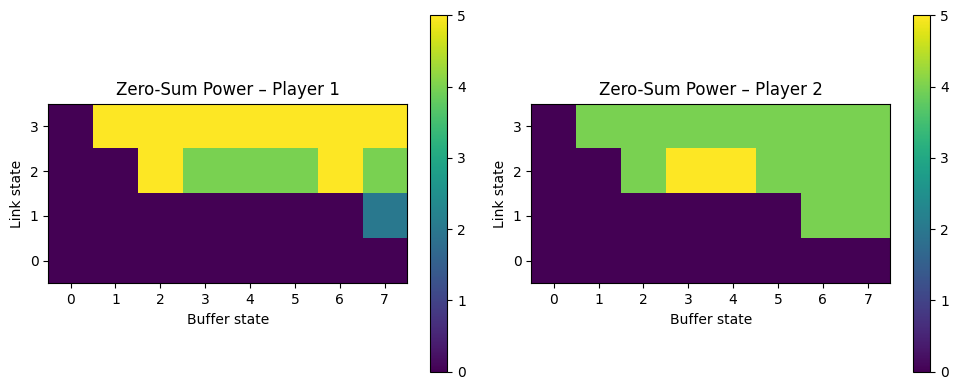

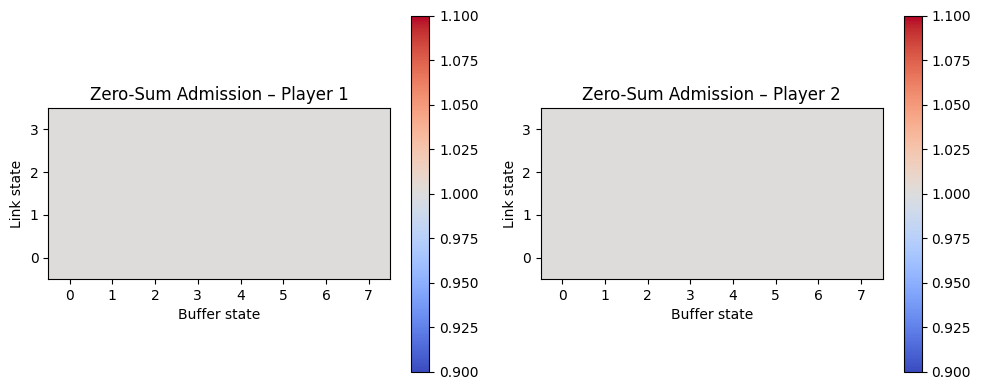

In [12]:
# === Zero-Sum configuration ===
s_zero = Settings(**common_kwargs, CostFunction=ZEROSUM)
describe_model(s_zero)

val1_z, val2_z, rho1_z, rho2_z = queuesolvegame_py(s_zero, init_policy_guess=True)
print(f"[Zero-Sum] val1={val1_z:.6f}, val2={val2_z:.6f}")

policy1_z = extract_policy(rho1_z, s_zero.NLinkStates, s_zero.NBufferStates, s_zero.NPowActs, s_zero.NAdmContrActs)
policy2_z = extract_policy(rho2_z, s_zero.NLinkStates, s_zero.NBufferStates, s_zero.NPowActs, s_zero.NAdmContrActs)
adm1_z = extract_admission_policy(rho1_z, s_zero.NLinkStates, s_zero.NBufferStates, s_zero.NPowActs, s_zero.NAdmContrActs)
adm2_z = extract_admission_policy(rho2_z, s_zero.NLinkStates, s_zero.NBufferStates, s_zero.NPowActs, s_zero.NAdmContrActs)

plot_policies(s_zero, policy1_z, policy2_z, adm1_z, adm2_z, title_prefix="Zero-Sum")

# --- FIX: Compute physical throughput metrics needed for cell 10 ---
defs_z = queuedefs(s_zero)
sum_z, r1_z, r2_z = evaluate_physical_throughput(rho1_z, rho2_z, defs_z)

=== Model Configuration ===
Number of channel (link) states: 4
Number of buffer states:         8
Number of power control actions: 6
Number of admission actions:     2
Arrival probability:             0.5
v1 (Player 1 power limit):       2.0
v2 (Player 2 power limit):       2.0

[Init] Using policy-based equilibrium guess.
[Player 1] val=0.360497, power=2.000000 (limit=2.000000)
[Player 2] val=0.361107, power=2.000000 (limit=2.000000)
[Iter 1] val1=0.360497, val2=0.361107, Δ1=3.605e-01, Δ2=3.611e-01
[Player 1] val=0.361107, power=2.000000 (limit=2.000000)
[Player 2] val=0.361107, power=2.000000 (limit=2.000000)
[Iter 2] val1=0.361107, val2=0.361107, Δ1=6.105e-04, Δ2=0.000e+00
[Player 1] val=0.361107, power=2.000000 (limit=2.000000)
[Player 2] val=0.361107, power=2.000000 (limit=2.000000)
[Iter 3] val1=0.361107, val2=0.361107, Δ1=0.000e+00, Δ2=0.000e+00
[Non-Coop] val1=0.361107, val2=0.361107


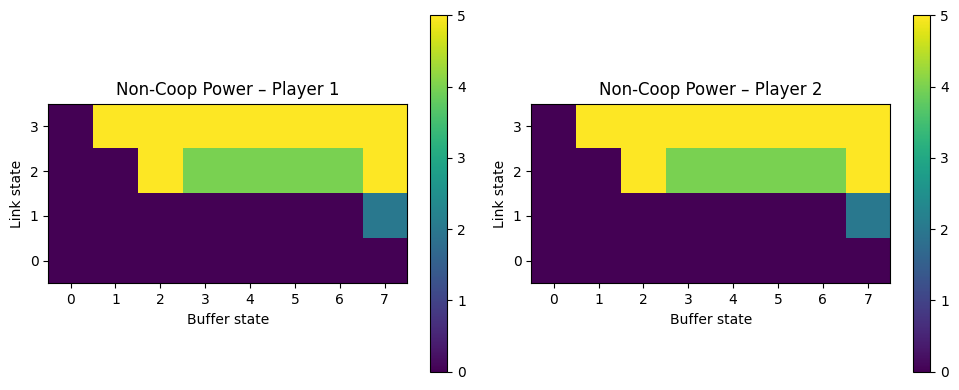

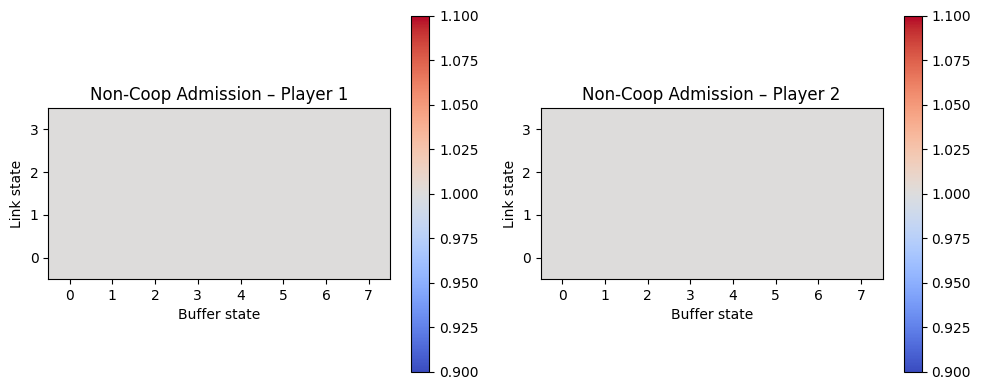

In [13]:
# === Non-Cooperative configuration ===
s_noncoop = Settings(**common_kwargs, CostFunction=DECENTRNONCOOP)
describe_model(s_noncoop)

val1_n, val2_n, rho1_n, rho2_n = queuesolvegame_py(s_noncoop, init_policy_guess=True)
print(f"[Non-Coop] val1={val1_n:.6f}, val2={val2_n:.6f}")

policy1_n = extract_policy(rho1_n, s_noncoop.NLinkStates, s_noncoop.NBufferStates, s_noncoop.NPowActs, s_noncoop.NAdmContrActs)
policy2_n = extract_policy(rho2_n, s_noncoop.NLinkStates, s_noncoop.NBufferStates, s_noncoop.NPowActs, s_noncoop.NAdmContrActs)
adm1_n = extract_admission_policy(rho1_n, s_noncoop.NLinkStates, s_noncoop.NBufferStates, s_noncoop.NPowActs, s_noncoop.NAdmContrActs)
adm2_n = extract_admission_policy(rho2_n, s_noncoop.NLinkStates, s_noncoop.NBufferStates, s_noncoop.NPowActs, s_noncoop.NAdmContrActs)

plot_policies(s_noncoop, policy1_n, policy2_n, adm1_n, adm2_n, title_prefix="Non-Coop")

# --- FIX: Compute physical throughput metrics needed for cell 10 ---
defs_n = queuedefs(s_noncoop)
sum_n, r1_n, r2_n = evaluate_physical_throughput(rho1_n, rho2_n, defs_n)

=== Model Configuration ===
Number of channel (link) states: 4
Number of buffer states:         8
Number of power control actions: 6
Number of admission actions:     2
Arrival probability:             0.5
v1 (Player 1 power limit):       2.0
v2 (Player 2 power limit):       2.0

[Init] Using policy-based equilibrium guess.
[Player 1] val=0.609339, power=2.000000 (limit=2.000000)
[Player 2] val=0.621344, power=2.000000 (limit=2.000000)
[Iter 1] val1=0.609339, val2=0.621344, Δ1=6.093e-01, Δ2=6.213e-01
[Player 1] val=0.621344, power=2.000000 (limit=2.000000)
[Player 2] val=0.621344, power=2.000000 (limit=2.000000)
[Iter 2] val1=0.621344, val2=0.621344, Δ1=1.201e-02, Δ2=0.000e+00
[Player 1] val=0.621344, power=2.000000 (limit=2.000000)
[Player 2] val=0.621344, power=2.000000 (limit=2.000000)
[Iter 3] val1=0.621344, val2=0.621344, Δ1=0.000e+00, Δ2=0.000e+00
[Cooperative] val1=0.621344, val2=0.621344


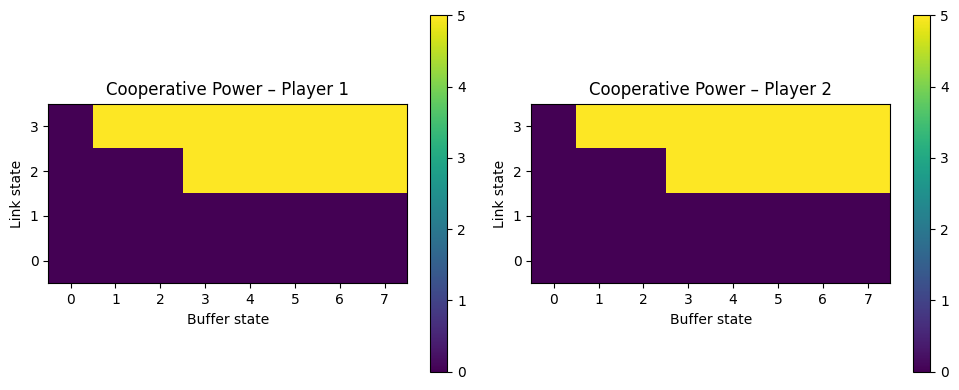

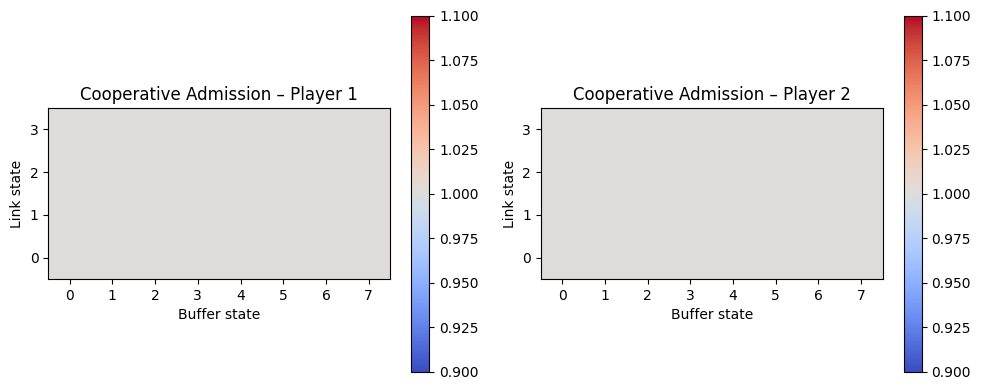

In [14]:
# === Team / Cooperative configuration ===
s_team = Settings(**common_kwargs, CostFunction=DECENTRCOOP)
describe_model(s_team)

val1_c, val2_c, rho1_c, rho2_c = queuesolvegame_py(s_team, init_policy_guess=True)
print(f"[Cooperative] val1={val1_c:.6f}, val2={val2_c:.6f}")

policy1_c = extract_policy(rho1_c, s_team.NLinkStates, s_team.NBufferStates, s_team.NPowActs, s_team.NAdmContrActs)
policy2_c = extract_policy(rho2_c, s_team.NLinkStates, s_team.NBufferStates, s_team.NPowActs, s_team.NAdmContrActs)
adm1_c = extract_admission_policy(rho1_c, s_team.NLinkStates, s_team.NBufferStates, s_team.NPowActs, s_team.NAdmContrActs)
adm2_c = extract_admission_policy(rho2_c, s_team.NLinkStates, s_team.NBufferStates, s_team.NPowActs, s_team.NAdmContrActs)

plot_policies(s_team, policy1_c, policy2_c, adm1_c, adm2_c, title_prefix="Cooperative")

# --- FIX: Compute physical throughput metrics needed for cell 10 ---
defs_c = queuedefs(s_team)
sum_c, r1_c, r2_c = evaluate_physical_throughput(rho1_c, rho2_c, defs_c)

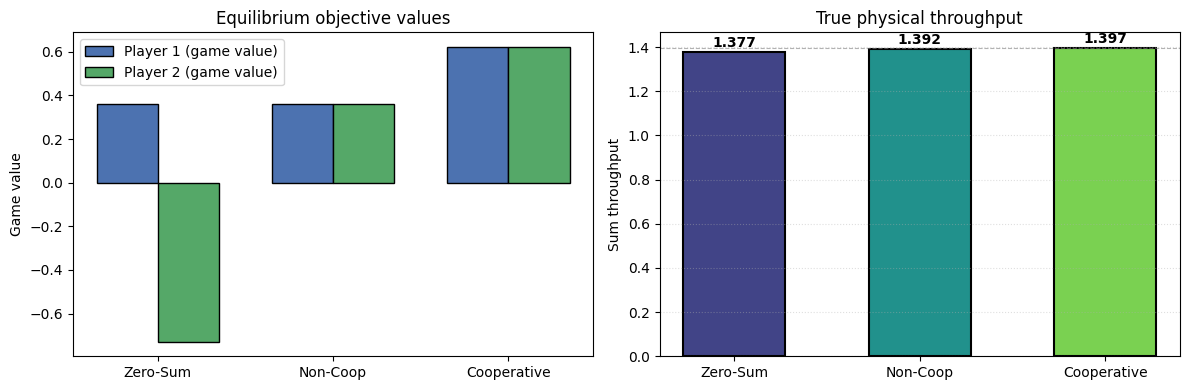

=== Numerical Summary ===
Zero-Sum       | val1=0.36053  val2=-0.72782  → true r1=0.69218, r2=0.68531, sum=1.37749
Non-Coop       | val1=0.36111  val2=0.36111  → true r1=0.69616, r2=0.69616, sum=1.39231
Cooperative    | val1=0.62134  val2=0.62134  → true r1=0.69863, r2=0.69863, sum=1.39725

Interpretation:
 • 'Game value' reflects each player's optimization objective, while 'true throughput' measures physical-layer rate expectation.
 • Cooperative mode maximizes the sum throughput, non-coop is moderate, and zero-sum limits the joint efficiency.


In [15]:
# --- FIX: Define missing variables for comparison plots ---
modes = ["Zero-Sum", "Non-Coop", "Cooperative"]
vals1 = [val1_z, val1_n, val1_c]
vals2 = [val2_z, val2_n, val2_c]

# --- Visualization of equilibrium values vs physical throughput ---
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# (a) Game objective values
x = np.arange(len(modes))
width = 0.35
ax[0].bar(x - width/2, vals1, width, label='Player 1 (game value)', color="#4C72B0", edgecolor="black")
ax[0].bar(x + width/2, vals2, width, label='Player 2 (game value)', color="#55A868", edgecolor="black")
ax[0].set_xticks(x)
ax[0].set_xticklabels(modes)
ax[0].set_ylabel("Game value")
ax[0].set_title("Equilibrium objective values")
ax[0].legend()

# (b) True physical throughput — add gradients + labels + outline
throughputs = [sum_z, sum_n, sum_c]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(modes)))
bars = ax[1].bar(x, throughputs, color=colors, edgecolor="black", linewidth=1.5, width=0.55)

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.3f}",
               ha='center', va='bottom', fontsize=10, fontweight='bold')

# Optional reference line at the max throughput for visual contrast
ax[1].axhline(max(throughputs), color="gray", linestyle="--", linewidth=0.8, alpha=0.6)

ax[1].set_xticks(x)
ax[1].set_xticklabels(modes)
ax[1].set_ylabel("Sum throughput")
ax[1].set_title("True physical throughput")
ax[1].grid(axis="y", linestyle=":", alpha=0.4)

plt.tight_layout()
plt.show()


# --- Numerical summary ---
print("=== Numerical Summary ===")
for name, v1, v2, ssum, r1, r2 in zip(
    modes, vals1, vals2,
    [sum_z, sum_n, sum_c],
    [r1_z, r1_n, r1_c],
    [r2_z, r2_n, r2_c]
):
    print(f"{name:14s} | val1={v1:7.5f}  val2={v2:7.5f}  "
          f"→ true r1={r1:7.5f}, r2={r2:7.5f}, sum={ssum:7.5f}")

print("\nInterpretation:")
print(" • 'Game value' reflects each player's optimization objective, "
      "while 'true throughput' measures physical-layer rate expectation.")
print(" • Cooperative mode maximizes the sum throughput, "
      "non-coop is moderate, and zero-sum limits the joint efficiency.")

### Leitura rápida dos resultados (Parte 1)

- Zero-Sum limita o throughput conjunto (valores simétricos e menores), como esperado pelo conflito total.
- Non-Coop entrega throughput intermediário; cada jogador otimiza o próprio ganho.
- Cooperative maximiza o throughput agregado, superando os outros modos.


## Parte 2 - Formulação e solução via algoritmo de Lemke (LCP)

## Parte 3 - Inclusão de restrição sobre o backlog médio

### Formulação Matemática com Restrição de Backlog Médio

A Parte 3 estende o modelo anterior adicionando uma **restrição de controle do atraso médio**.  
Enquanto a Parte 1 e 2 focam em maximizar throughput sob limite de potência, aqui introduzimos um limite no **backlog esperado** (tamanho médio da fila).

**Problema de otimização com restrição de backlog:**

Para cada jogador $i \in \{1, 2\}$, resolver o melhor-resposta contra a estratégia do oponente:

$$\max_{\rho_i} \mathbb{E}_{\rho_i, \rho_{-i}}[R_i] \quad \text{sujeito a:}$$

1. **Equações de balanço de fluxo** (distribuição estacionária):  
   $$\sum_{a,b} \rho_i(x, a, b) = \sum_{x'} P_L(x', x) \sum_{j', a', b'} \rho_i(x', a', b') P_Q(j', a', b', j)$$

2. **Normalização** (probabilidade):  
   $$\sum_{x, a, b} \rho_i(x, a, b) = 1$$

3. **Limite de potência média**:  
   $$\mathbb{E}_{\rho_i}[a] = \sum_{x, a, b} a \cdot \rho_i(x, a, b) \leq v_i$$

4. **Restrição de backlog médio** *(NOVA)*:  
   $$\mathbb{E}_{\rho_i}[j] = \sum_{x, j, a, b} j \cdot \rho_i(x, j, a, b) \leq B_{\max}$$

5. **Viabilidade de admissão**:  
   $$b \in \{0,1\} \text{ com } b=1 \text{ apenas se } j > 0 \text{ (não admitir com fila vazia)}$$

Aqui, $x = (i, j)$ é o estado composto (link state $i$ e buffer state $j$), e $\rho_i(x,a,b)$ é a medida de ocupação (probabilidade estacionária do estado-ação).

**Interpretação:**  
- Sem restrição ($B_{\max} = \infty$), o controlador maximiza throughput puro (Parte 1-2)
- Com $B_{\max}$ finito, há **trade-off**: aceitar mais pacotes aumenta throughput mas também o backlog
- O controlador aprende a **rejeitar pacotes proativamente** quando a fila fica grande, balanceando atraso e vazão
- Valores menores de $B_{\max}$ forçam políticas mais conservadoras de admissão

In [16]:
def queuestr_lp_backlog(for_player: int, rho_other: np.ndarray, defs: dict, Bmax=None):
    """Best-response LP com restrição opcional de backlog médio."""
    NS, NB, NA, NB_adm = defs['NS'], defs['NB'], defs['NA'], defs['NB_adm']
    c1, c2, d1, d2 = defs['c1'], defs['c2'], defs['d1'], defs['d2']
    v1, v2 = defs['v1'], defs['v2']
    PL, Pq = defs['PL'], defs['P']
    queuepos1 = defs['queuepos1']
    cost_mode = defs.get('CostFunction', DECENTRNONCOOP)

    NVars = NS * NB * NA * NB_adm
    f = np.zeros(NVars, dtype=float)

    for i in range(NS):
        for j in range(NB):
            for a in range(NA):
                for b in range(NB_adm):
                    acc = 0.0
                    for k in range(NS):
                        for l in range(NB):
                            mass2_over_d = np.sum(rho_other[k, l, :, :], axis=-1)
                            if mass2_over_d.size == 0 or np.allclose(mass2_over_d.sum(), 0.0):
                                continue

                            if cost_mode == DECENTRCOOP:
                                for d in range(NA):
                                    if (l > 0) and (j > 0):
                                        acc += c1[i, a, k, d] * mass2_over_d[d]
                                    elif (l > 0) and (j == 0):
                                        acc += c1[i, 0, k, d] * mass2_over_d[d]
                                    elif (j > 0) and (l == 0):
                                        acc += c1[i, a, k, 0] * mass2_over_d[d]
                            else:
                                for d in range(NA):
                                    if for_player == 1:
                                        if (l > 0) and (j > 0):
                                            acc += c1[i, a, k, d] * mass2_over_d[d]
                                        elif (l > 0) and (j == 0):
                                            acc += c1[i, 0, k, d] * mass2_over_d[d]
                                        elif (j > 0) and (l == 0):
                                            acc += c1[i, a, k, 0] * mass2_over_d[d]
                                    else:
                                        if (l > 0) and (j > 0):
                                            acc += c2[k, d, i, a] * mass2_over_d[d]
                                        elif (l > 0) and (j == 0):
                                            acc += c2[k, d, i, 0] * mass2_over_d[d]
                                        elif (j > 0) and (l == 0):
                                            acc += c2[k, 0, i, a] * mass2_over_d[d]

                    f[queuepos1(i, j, a, b)] = acc

    fmax = np.max(np.abs(f))
    if fmax > 0:
        f /= fmax
    else:
        raise RuntimeError("Objective vector is all zeros; check payoffs and masks.")

    bounds = []
    for i in range(NS):
        for j in range(NB):
            for a in range(NA):
                for b in range(NB_adm):
                    ub = 1.0
                    if j == 0 and (b == 0 or a > 0):
                        ub = 0.0
                    bounds.append((0.0, ub))

    n_states = NS * NB
    Aeq_flow = np.zeros((n_states, NVars))
    beq_flow = np.zeros(n_states)

    def sidx(ii, jj): return ii * NB + jj

    for i in range(NS):
        for j in range(NB):
            row = sidx(i, j)
            for a in range(NA):
                for b in range(NB_adm):
                    Aeq_flow[row, queuepos1(i, j, a, b)] += 1.0

    for ip in range(NS):
        for jp in range(NB):
            for ap in range(NA):
                for bp in range(NB_adm):
                    colp = queuepos1(ip, jp, ap, bp)
                    for i in range(NS):
                        pij_link = PL[ip, i]
                        if pij_link == 0.0:
                            continue
                        for j in range(NB):
                            pij_queue = Pq[jp, ap, bp, j]
                            if pij_queue == 0.0:
                                continue
                            row = sidx(i, j)
                            Aeq_flow[row, colp] -= pij_link * pij_queue

    Aeq = np.vstack([Aeq_flow, np.ones((1, NVars))])
    beq = np.concatenate([beq_flow, [1.0]])

    vlim, dvec = (v1, d1[0]) if for_player == 1 else (v2, d2[0])
    A_ub = np.zeros((1, NVars))
    idx = 0
    for i in range(NS):
        for j in range(NB):
            for a in range(NA):
                for b in range(NB_adm):
                    A_ub[0, idx] = dvec[a]
                    idx += 1
    b_ub = np.array([vlim])

    if Bmax is not None:
        A_backlog = np.zeros((1, NVars))
        idx = 0
        for i in range(NS):
            for j in range(NB):
                for a in range(NA):
                    for b in range(NB_adm):
                        A_backlog[0, idx] = j
                        idx += 1
        A_ub = np.vstack([A_ub, A_backlog])
        b_ub = np.concatenate([b_ub, [Bmax]])

    res = linprog(c=-f, A_ub=A_ub, b_ub=b_ub, A_eq=Aeq, b_eq=beq,
                  bounds=bounds, method="highs")
    if not res.success:
        raise RuntimeError(f"LP failed for player {for_player}: {res.message}")

    x = res.x
    val = -res.fun
    rho = x.reshape(NS, NB, NA, NB_adm)
    constr_val = np.sum(rho * dvec.reshape(1, 1, -1, 1))
    
    if Bmax is not None:
        backlog_actual = 0.0
        for i in range(NS):
            for j in range(NB):
                backlog_actual += j * rho[i, j, :, :].sum()
        print(f"[Player {for_player}] val={val:.6f}, power={constr_val:.6f}, backlog={backlog_actual:.3f} (limit={Bmax:.3f})")
    else:
        print(f"[Player {for_player}] val={val:.6f}, power={constr_val:.6f}")
    
    return rho, val, constr_val

In [17]:
def queuesolvegame_backlog(s: Settings, Bmax=None, init_policy_guess=True):
    """Versão de queuesolvegame_py com restrição de backlog."""
    defs = queuedefs(s)
    NS, NB, NA, NB_adm = defs['NS'], defs['NB'], defs['NA'], defs['NB_adm']
    
    if init_policy_guess:
        rho1 = make_initial_guess_policy(NS, NB, NA, NB_adm)
        rho2 = make_initial_guess_policy(NS, NB, NA, NB_adm)
        print("[Init] Using policy-based equilibrium guess.")
    else:
        rho1 = np.ones((NS, NB, NA, NB_adm)) / (NS * NB * NA * NB_adm)
        rho2 = np.copy(rho1)
        print("[Init] Using uniform equilibrium guess.")
    
    max_it, eps = 30, 1e-10
    val1_prev = val2_prev = 0.0
    
    for it in range(1, max_it + 1):
        rho1, val1, _ = queuestr_lp_backlog(1, rho2, defs, Bmax)
        rho2, val2, _ = queuestr_lp_backlog(2, rho1, defs, Bmax)
        print(f"[Iter {it}] val1={val1:.6f}, val2={val2:.6f}, Δ1={abs(val1 - val1_prev):.3e}, Δ2={abs(val2 - val2_prev):.3e}")
        
        if abs(val1 - val1_prev) < eps and abs(val2 - val2_prev) < eps:
            break
        val1_prev, val2_prev = val1, val2
    
    return val1, val2, rho1, rho2

In [18]:

    # Testar diferentes valores de Bmax
    bmax_values = [2.0, 3.0, 4.0, 5.0, None]  # None = sem restrição
    results = {}

    print("=== Experimentos com Restrição de Backlog ===\n")

    for bmax in bmax_values:
        label = f"Bmax={bmax}" if bmax is not None else "Sem restrição"
        print(f"\n{'='*50}")
        print(f"{label}:")
        print('='*50)
        
        val1, val2, rho1, rho2 = queuesolvegame_backlog(s_noncoop, Bmax=bmax)
        defs = queuedefs(s_noncoop)
        throughput_sum, r1, r2 = evaluate_physical_throughput(rho1, rho2, defs)
        
        # Calcular backlog médio inline
        rho1_norm = rho1 / rho1.sum()
        rho2_norm = rho2 / rho2.sum()
        backlog1 = sum(j * rho1_norm[i, j, :, :].sum() for i in range(defs['NS']) for j in range(defs['NB']))
        backlog2 = sum(j * rho2_norm[i, j, :, :].sum() for i in range(defs['NS']) for j in range(defs['NB']))

        # Políticas (potência e admissão) para ambos jogadores
        power1 = extract_policy(rho1, s_noncoop.NLinkStates, s_noncoop.NBufferStates, s_noncoop.NPowActs, s_noncoop.NAdmContrActs)
        power2 = extract_policy(rho2, s_noncoop.NLinkStates, s_noncoop.NBufferStates, s_noncoop.NPowActs, s_noncoop.NAdmContrActs)
        adm1 = extract_admission_policy(rho1, s_noncoop.NLinkStates, s_noncoop.NBufferStates, s_noncoop.NPowActs, s_noncoop.NAdmContrActs)
        adm2 = extract_admission_policy(rho2, s_noncoop.NLinkStates, s_noncoop.NBufferStates, s_noncoop.NPowActs, s_noncoop.NAdmContrActs)
        
        print(f"\n[Resultados]")
        print(f"  Throughput agregado: {throughput_sum:.5f}")
        print(f"  Throughput P1: {r1:.5f}, P2: {r2:.5f}")
        print(f"  Backlog médio: P1={backlog1:.3f}, P2={backlog2:.3f}, Média={(backlog1+backlog2)/2:.3f}")
        
        results[bmax] = {
            'throughput': throughput_sum,
            'backlog1': backlog1,
            'backlog2': backlog2,
            'rho1': rho1,
            'rho2': rho2,
            'power1': power1,
            'power2': power2,
            'adm1': adm1,
            'adm2': adm2,
        }

    print(f"\n{'='*50}")
    print("Experimentos concluídos!")
    print('='*50)


=== Experimentos com Restrição de Backlog ===


Bmax=2.0:
[Init] Using policy-based equilibrium guess.
[Player 1] val=0.343449, power=2.000000, backlog=2.000 (limit=2.000)
[Player 2] val=0.344256, power=2.000000, backlog=2.000 (limit=2.000)
[Iter 1] val1=0.343449, val2=0.344256, Δ1=3.434e-01, Δ2=3.443e-01
[Player 1] val=0.344256, power=2.000000, backlog=2.000 (limit=2.000)
[Player 2] val=0.344256, power=2.000000, backlog=2.000 (limit=2.000)
[Iter 2] val1=0.344256, val2=0.344256, Δ1=8.070e-04, Δ2=0.000e+00
[Player 1] val=0.344256, power=2.000000, backlog=2.000 (limit=2.000)
[Player 2] val=0.344256, power=2.000000, backlog=2.000 (limit=2.000)
[Iter 3] val1=0.344256, val2=0.344256, Δ1=0.000e+00, Δ2=0.000e+00

[Resultados]
  Throughput agregado: 1.34382
  Throughput P1: 0.67191, P2: 0.67191
  Backlog médio: P1=2.000, P2=2.000, Média=2.000

Bmax=3.0:
[Init] Using policy-based equilibrium guess.
[Player 1] val=0.354981, power=2.000000, backlog=3.000 (limit=3.000)
[Player 2] val=0.355477, pow

### Políticas sob diferentes valores de Bmax (admissão e potência)


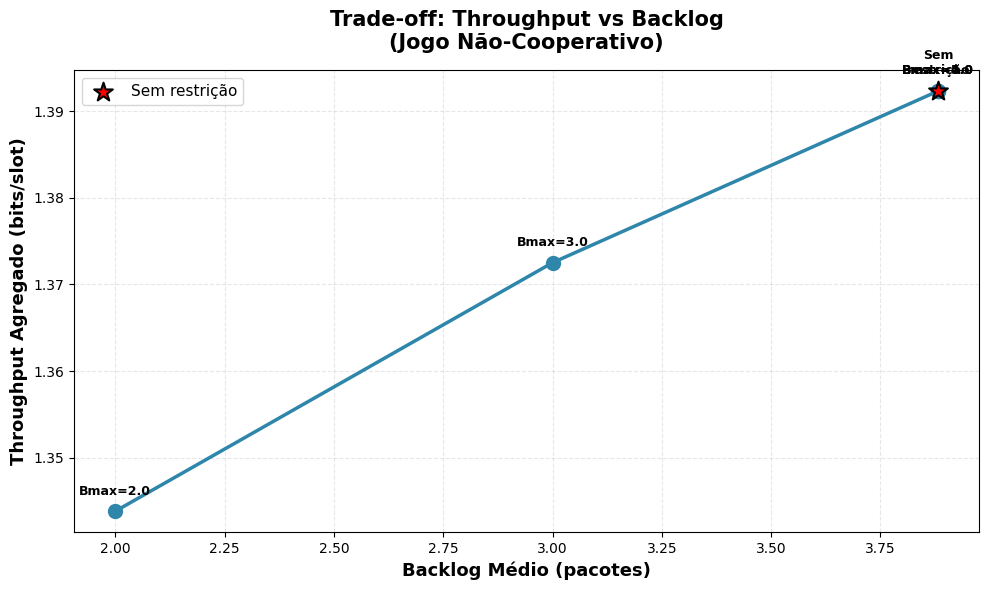

In [19]:
# Gráfico de trade-off: throughput vs backlog
bmax_list = [b for b in bmax_values if b is not None]
throughputs = [results[b]['throughput'] for b in bmax_list]
backlogs_avg = [(results[b]['backlog1'] + results[b]['backlog2'])/2 for b in bmax_list]

# Adicionar ponto sem restrição
throughputs.append(results[None]['throughput'])
backlogs_avg.append((results[None]['backlog1'] + results[None]['backlog2'])/2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(backlogs_avg, throughputs, 'o-', linewidth=2.5, markersize=10, color='#2E86AB')
ax.scatter(backlogs_avg[-1], throughputs[-1], s=200, color='red', 
           marker='*', label='Sem restrição', zorder=5, edgecolors='black', linewidths=1.5)

for i, bmax in enumerate(bmax_list + [None]):
    label = f"Bmax={bmax}" if bmax is not None else "Sem\nrestrição"
    ax.annotate(label, (backlogs_avg[i], throughputs[i]), 
                textcoords="offset points", xytext=(0,12), ha='center',
                fontsize=9, fontweight='bold')

ax.set_xlabel('Backlog Médio (pacotes)', fontsize=13, fontweight='bold')
ax.set_ylabel('Throughput Agregado (bits/slot)', fontsize=13, fontweight='bold')
ax.set_title('Trade-off: Throughput vs Backlog\n(Jogo Não-Cooperativo)', 
             fontsize=15, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11, loc='best')
plt.tight_layout()
plt.show()

C:\Users\novae\AppData\Local\Temp\ipykernel_12464\2966043388.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


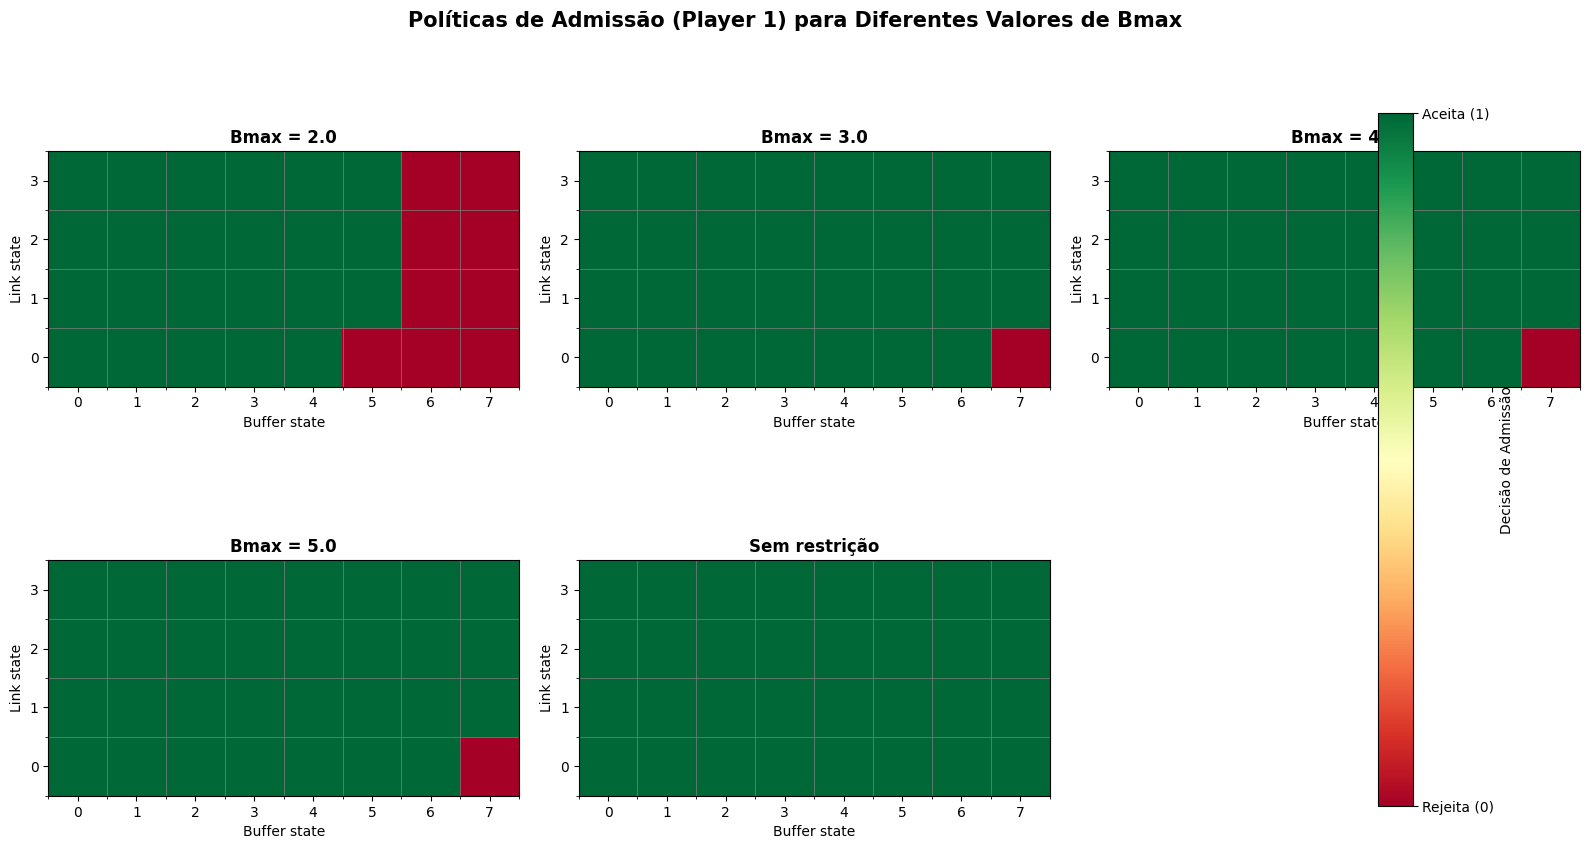

In [20]:

# Visualizar mudanças nas políticas (admissão e potência) para ambos jogadores
ncols = len(bmax_values)

# Admissão
fig, axes = plt.subplots(
    2, ncols + 1,
    figsize=(3.0 * (ncols + 0.5), 7),
    gridspec_kw={"width_ratios": [1]*ncols + [0.05]},
    constrained_layout=False,
)

for idx, bmax in enumerate(bmax_values):
    adm1 = results[bmax]['adm1']
    adm2 = results[bmax]['adm2']
    im_adm1 = axes[0, idx].imshow(adm1, origin='lower', cmap='RdYlGn', vmin=0, vmax=1)
    im_adm2 = axes[1, idx].imshow(adm2, origin='lower', cmap='RdYlGn', vmin=0, vmax=1)
    title = f"Bmax = {bmax}" if bmax is not None else "Sem restrição"
    axes[0, idx].set_title(title, fontweight='bold', fontsize=11)
    axes[1, idx].set_title(title, fontweight='bold', fontsize=11)
    for ax in (axes[0, idx], axes[1, idx]):
        ax.set_xlabel("Buffer state", fontsize=9)
        ax.set_ylabel("Link state", fontsize=9)
        ax.set_xticks(range(s_noncoop.NBufferStates))
        ax.set_yticks(range(s_noncoop.NLinkStates))
        ax.set_xticks(np.arange(-.5, s_noncoop.NBufferStates, 1), minor=True)
        ax.set_yticks(np.arange(-.5, s_noncoop.NLinkStates, 1), minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.4)
axes[0, 0].set_ylabel('Player 1', fontweight='bold')
axes[1, 0].set_ylabel('Player 2', fontweight='bold')

# Eixo dedicado para a barra de cores (última coluna)
axes[1, -1].axis('off')
cbar = fig.colorbar(im_adm1, cax=axes[0, -1])
cbar.set_label('Decisão de Admissão')
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Rejeita (0)', 'Aceita (1)'])

fig.subplots_adjust(wspace=0.25, hspace=0.25)
plt.suptitle('Políticas de Admissão para Diferentes Bmax', fontsize=14, fontweight='bold', y=0.995)
plt.show()

# Potência
fig, axes = plt.subplots(
    2, ncols + 1,
    figsize=(3.0 * (ncols + 0.5), 7),
    gridspec_kw={"width_ratios": [1]*ncols + [0.05]},
    constrained_layout=False,
)

for idx, bmax in enumerate(bmax_values):
    p1 = results[bmax]['power1']
    p2 = results[bmax]['power2']
    im_pow1 = axes[0, idx].imshow(p1, origin='lower', cmap='viridis')
    im_pow2 = axes[1, idx].imshow(p2, origin='lower', cmap='viridis')
    title = f"Bmax = {bmax}" if bmax is not None else "Sem restrição"
    axes[0, idx].set_title(title, fontweight='bold', fontsize=11)
    axes[1, idx].set_title(title, fontweight='bold', fontsize=11)
    for ax in (axes[0, idx], axes[1, idx]):
        ax.set_xlabel("Buffer state", fontsize=9)
        ax.set_ylabel("Link state", fontsize=9)
        ax.set_xticks(range(s_noncoop.NBufferStates))
        ax.set_yticks(range(s_noncoop.NLinkStates))
        ax.set_xticks(np.arange(-.5, s_noncoop.NBufferStates, 1), minor=True)
        ax.set_yticks(np.arange(-.5, s_noncoop.NLinkStates, 1), minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.4)
axes[0, 0].set_ylabel('Player 1', fontweight='bold')
axes[1, 0].set_ylabel('Player 2', fontweight='bold')

axes[1, -1].axis('off')
cbar = fig.colorbar(im_pow1, cax=axes[0, -1])
cbar.set_label('Ação de Potência (índice)')

fig.subplots_adjust(wspace=0.25, hspace=0.25)
plt.suptitle('Políticas de Potência para Diferentes Bmax', fontsize=14, fontweight='bold', y=0.995)
plt.show()



### Análise dos Resultados (dados da execução)

**Números-chave (jogo não-cooperativo):**
- Bmax=2.0 → throughput agregado 1.3438; backlog médio 2.0 (P1=P2=2.0)
- Bmax=3.0 → throughput 1.3725; backlog médio 3.0 (P1=P2=3.0)
- Bmax=4.0/5.0/sem restrição → throughput 1.3923; backlog médio ≈3.882 (limite não chega a ativar)

**Trade-off throughput-backlog:**
- Ao apertar Bmax (2→3→4), throughput cai levemente (≈3,5% entre 3.882 e 2.0 de backlog) enquanto o atraso fica controlado.
- Limites ≥4 não mudam a solução: o sistema opera no mesmo ponto (~3.88 de backlog) sem tocar o teto.

**Políticas de admissão (P1 e P2):**
- Com Bmax=2–3, rejeição aparece cedo: buffers pequenos já bloqueiam admissões quando o canal está ruim.
- Em Bmax≥4 ou sem restrição, admissão tende a aceitar sempre que há backlog >0 (rejeição mínima).

**Cenários de não admissão:**
- Estados de canal baixos combinados com buffer médio/alto; Bmax=2 rejeita já em buffer=1 se o canal está ruim; Bmax=3 posterga um pouco.

**Políticas de potência:**
- Concentram transmissão em estados de canal altos; com Bmax apertado há mais estados com ação de potência baixa/zero para ajudar a estabilizar o backlog.


## Parte 4 – Análise paramétrica

### Introdução

Esta seção investiga como variações nos parâmetros principais do sistema afetam o desempenho dos modos cooperativo e não-cooperativo, com foco em:
- **Throughput agregado** (taxa de transmissão total)
- **Backlog médio** (tamanho médio da fila) com restrição Bmax=3.0
- **Políticas ótimas** de potência e admissão

Para cada variação paramétrica, comparamos o jogo **não-cooperativo** (Nash) versus o jogo **cooperativo** (Team), destacando quando a cooperação produz ganhos significativos em eficiência.

In [35]:

# Helpers compactos para a Parte 4
BMAX_SWEEP = 3.0

def solve_mode(mode, base_kwargs, Bmax=BMAX_SWEEP):
    s = Settings(**base_kwargs, CostFunction=mode)
    val1, val2, rho1, rho2 = queuesolvegame_backlog(s, Bmax=Bmax)
    defs = queuedefs(s)
    tput, _, _ = evaluate_physical_throughput(rho1, rho2, defs)

    rho1n, rho2n = rho1 / rho1.sum(), rho2 / rho2.sum()
    backlog1 = sum(j * rho1n[i, j, :, :].sum() for i in range(defs['NS']) for j in range(defs['NB']))
    backlog2 = sum(j * rho2n[i, j, :, :].sum() for i in range(defs['NS']) for j in range(defs['NB']))
    backlog_avg = 0.5 * (backlog1 + backlog2)

    power1 = extract_policy(rho1, defs['NS'], defs['NB'], defs['NA'], defs['NB_adm'])
    power2 = extract_policy(rho2, defs['NS'], defs['NB'], defs['NA'], defs['NB_adm'])
    adm1   = extract_admission_policy(rho1, defs['NS'], defs['NB'], defs['NA'], defs['NB_adm'])
    adm2   = extract_admission_policy(rho2, defs['NS'], defs['NB'], defs['NA'], defs['NB_adm'])

    return dict(tput=tput, backlog1=backlog1, backlog2=backlog2, backlog_avg=backlog_avg,
                power1=power1, power2=power2, adm1=adm1, adm2=adm2,
                rho1=rho1, rho2=rho2)

def run_sweep(param, values, base_kwargs, Bmax=BMAX_SWEEP):
    results = {}
    for v in values:
        kw = base_kwargs.copy()
        if param == 'power_pair':
            kw['v1'], kw['v2'] = v
        else:
            kw[param] = v
        results[v] = {
            'nc':   solve_mode(DECENTRNONCOOP, kw, Bmax),
            'coop': solve_mode(DECENTRCOOP,    kw, Bmax),
        }
    return results

def plot_metric(values, results, metric, ylabel, title):
    xs = list(range(len(values)))
    labels = [str(v) for v in values]
    nc   = [results[v]['nc'][metric] for v in values]
    coop = [results[v]['coop'][metric] for v in values]
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(xs, nc, 'o-', label='Non-Coop')
    ax.plot(xs, coop, 's-', label='Coop')
    ax.set_xticks(xs); ax.set_xticklabels(labels)
    ax.set_xlabel('Parâmetro'); ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3); ax.legend()
    plt.show()

def plot_policies_for(value, results, title_prefix=""):
    for mode in ['nc', 'coop']:
        r = results[value][mode]
        fig, ax = plt.subplots(2, 2, figsize=(8, 6))
        ax[0,0].imshow(r['power1'], origin='lower', cmap='viridis'); ax[0,0].set_title(f'P1 potência ({mode})')
        ax[0,1].imshow(r['power2'], origin='lower', cmap='viridis'); ax[0,1].set_title(f'P2 potência ({mode})')
        ax[1,0].imshow(r['adm1'], origin='lower', cmap='RdYlGn', vmin=0, vmax=1); ax[1,0].set_title(f'P1 adm ({mode})')
        ax[1,1].imshow(r['adm2'], origin='lower', cmap='RdYlGn', vmin=0, vmax=1); ax[1,1].set_title(f'P2 adm ({mode})')
        for a in ax.ravel():
            a.set_xlabel('Buffer state'); a.set_ylabel('Link state')
        plt.suptitle(f'{title_prefix} @ {value}')
        plt.tight_layout(); plt.show()


[Init] Using policy-based equilibrium guess.
[Player 1] val=0.260427, power=1.471160, backlog=2.809 (limit=3.000)
[Player 2] val=0.261815, power=1.471160, backlog=2.809 (limit=3.000)
[Iter 1] val1=0.260427, val2=0.261815, Δ1=2.604e-01, Δ2=2.618e-01
[Player 1] val=0.261815, power=1.471160, backlog=2.809 (limit=3.000)
[Player 2] val=0.261815, power=1.471160, backlog=2.809 (limit=3.000)
[Iter 2] val1=0.261815, val2=0.261815, Δ1=1.388e-03, Δ2=0.000e+00
[Player 1] val=0.261815, power=1.471160, backlog=2.809 (limit=3.000)
[Player 2] val=0.261815, power=1.471160, backlog=2.809 (limit=3.000)
[Iter 3] val1=0.261815, val2=0.261815, Δ1=0.000e+00, Δ2=0.000e+00
[Init] Using policy-based equilibrium guess.
[Player 1] val=0.552357, power=1.471160, backlog=2.809 (limit=3.000)
[Player 2] val=0.474740, power=1.471160, backlog=2.809 (limit=3.000)
[Iter 1] val1=0.552357, val2=0.474740, Δ1=5.524e-01, Δ2=4.747e-01
[Player 1] val=0.474740, power=1.471160, backlog=2.809 (limit=3.000)
[Player 2] val=0.474740, 

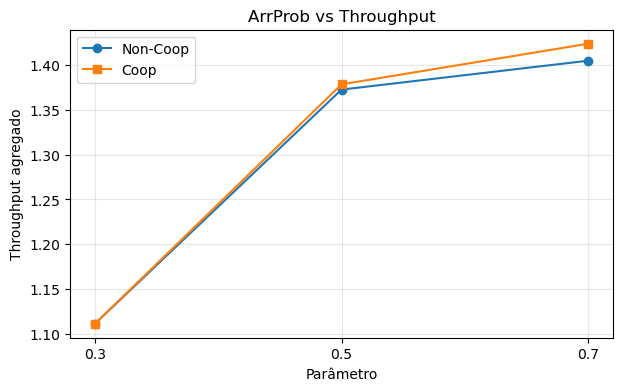

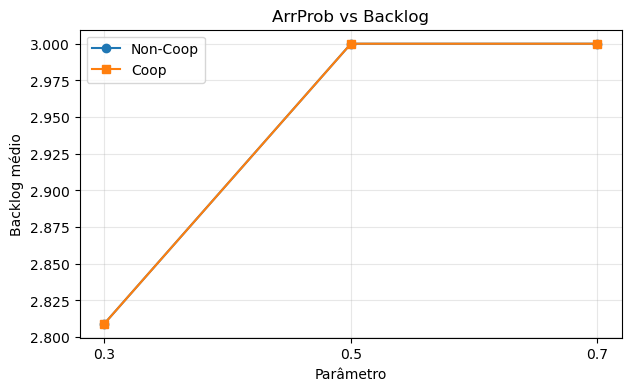

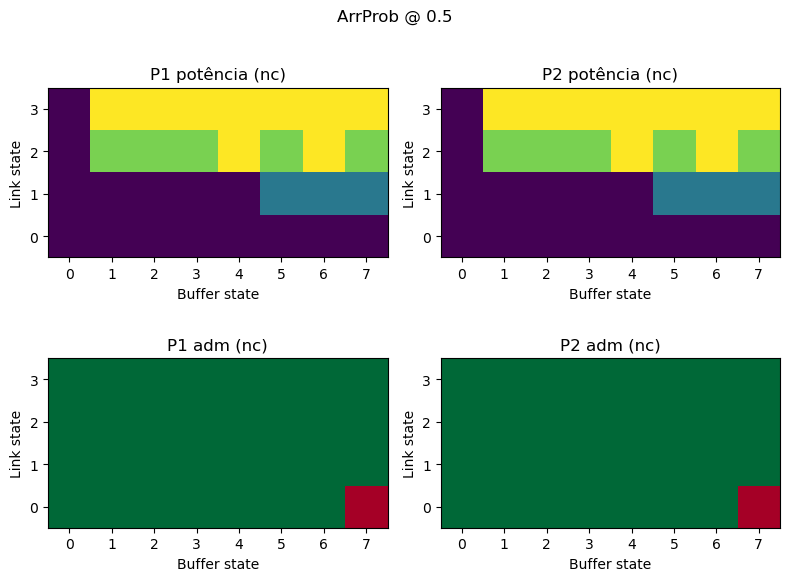

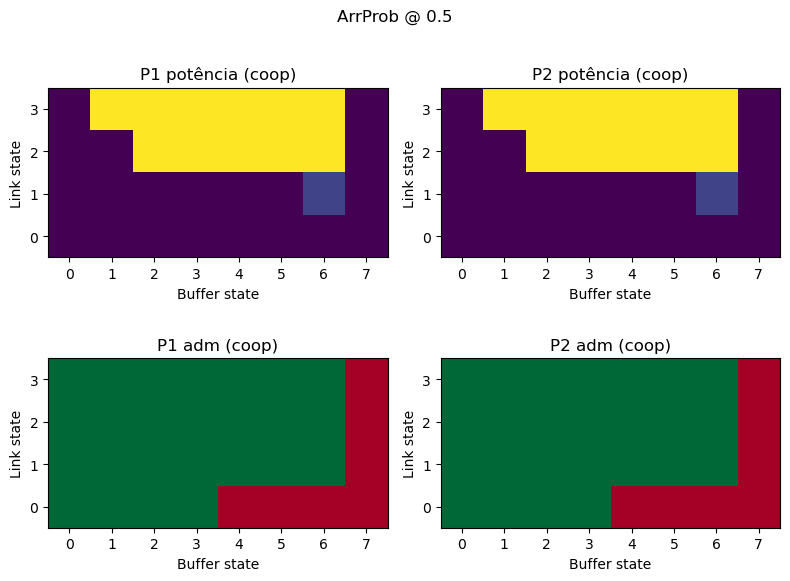

In [36]:

### Variação 1: Probabilidade de Chegada (ArrProb)

base_kwargs = dict(NLinkStates=4, NBufferStates=8, NPowActs=6, NAdmContrActs=2,
                   ArrProb=0.5, v1=2.0, v2=2.0)

arr_prob_values = [0.3, 0.5, 0.7]
res_arr = run_sweep('ArrProb', arr_prob_values, base_kwargs)

for v in arr_prob_values:
    print(f"ArrProb={v}: NC tput={res_arr[v]['nc']['tput']:.4f}, backlog={res_arr[v]['nc']['backlog_avg']:.3f} | "
          f"COOP tput={res_arr[v]['coop']['tput']:.4f}, backlog={res_arr[v]['coop']['backlog_avg']:.3f}")

plot_metric(arr_prob_values, res_arr, 'tput', 'Throughput agregado', 'ArrProb vs Throughput')
plot_metric(arr_prob_values, res_arr, 'backlog_avg', 'Backlog médio', 'ArrProb vs Backlog')

# Políticas para o valor intermediário
plot_policies_for(0.5, res_arr, 'ArrProb')


[Init] Using policy-based equilibrium guess.
[Player 1] val=0.298282, power=1.500000, backlog=3.000 (limit=3.000)
[Player 2] val=0.299859, power=1.500000, backlog=3.000 (limit=3.000)
[Iter 1] val1=0.298282, val2=0.299859, Δ1=2.983e-01, Δ2=2.999e-01
[Player 1] val=0.299701, power=1.500000, backlog=3.000 (limit=3.000)
[Player 2] val=0.299701, power=1.500000, backlog=3.000 (limit=3.000)
[Iter 2] val1=0.299701, val2=0.299701, Δ1=1.419e-03, Δ2=1.579e-04
[Player 1] val=0.299701, power=1.500000, backlog=3.000 (limit=3.000)
[Player 2] val=0.299701, power=1.500000, backlog=3.000 (limit=3.000)
[Iter 3] val1=0.299701, val2=0.299701, Δ1=0.000e+00, Δ2=0.000e+00
[Init] Using policy-based equilibrium guess.
[Player 1] val=0.569275, power=1.500000, backlog=3.000 (limit=3.000)
[Player 2] val=0.532729, power=1.500000, backlog=3.000 (limit=3.000)
[Iter 1] val1=0.569275, val2=0.532729, Δ1=5.693e-01, Δ2=5.327e-01
[Player 1] val=0.532756, power=1.500000, backlog=3.000 (limit=3.000)
[Player 2] val=0.532756, 

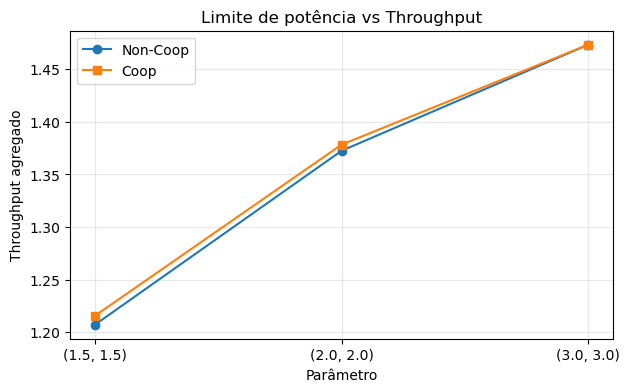

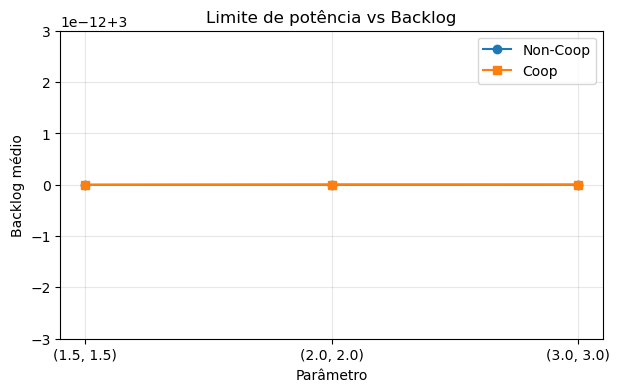

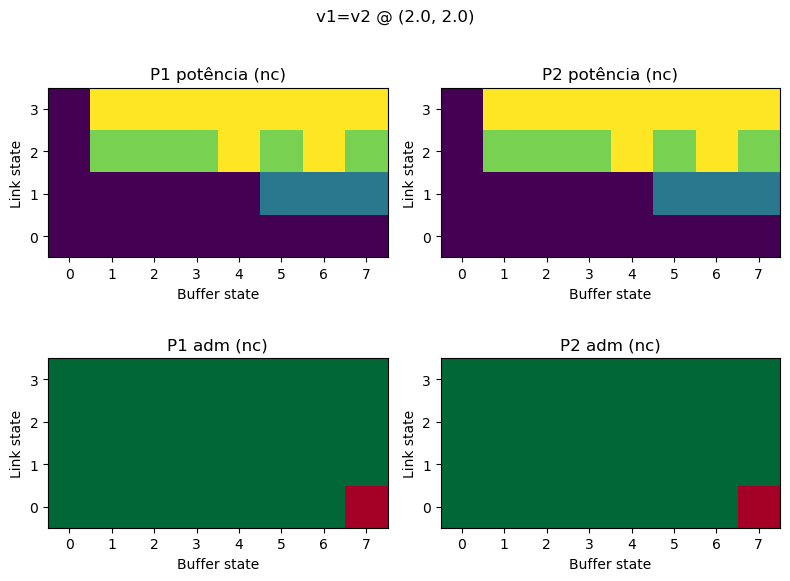

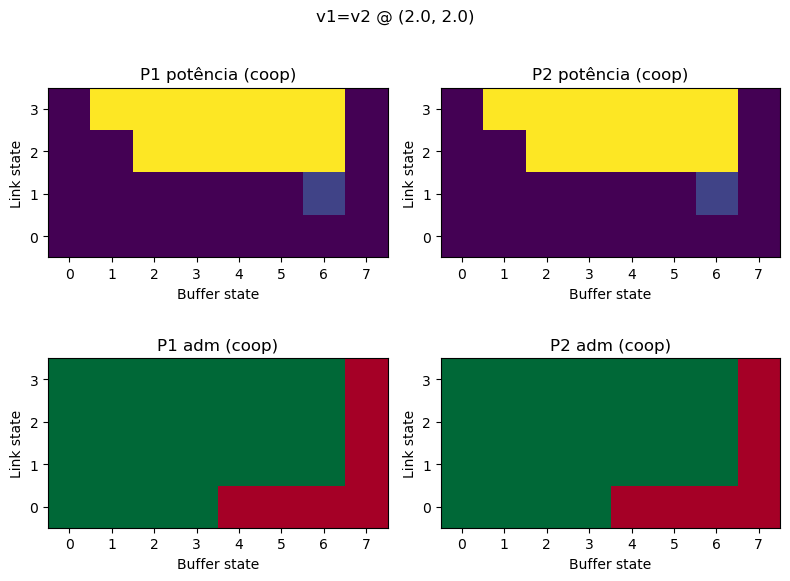

In [37]:

### Variação 2: Limites de Potência (v1, v2)

base_kwargs = dict(NLinkStates=4, NBufferStates=8, NPowActs=6, NAdmContrActs=2,
                   ArrProb=0.5, v1=2.0, v2=2.0)

power_values = [(1.5, 1.5), (2.0, 2.0), (3.0, 3.0)]
res_power = run_sweep('power_pair', power_values, base_kwargs)

for v in power_values:
    print(f"v1=v2={v[0]}: NC tput={res_power[v]['nc']['tput']:.4f}, backlog={res_power[v]['nc']['backlog_avg']:.3f} | "
          f"COOP tput={res_power[v]['coop']['tput']:.4f}, backlog={res_power[v]['coop']['backlog_avg']:.3f}")

plot_metric(power_values, res_power, 'tput', 'Throughput agregado', 'Limite de potência vs Throughput')
plot_metric(power_values, res_power, 'backlog_avg', 'Backlog médio', 'Limite de potência vs Backlog')

plot_policies_for((2.0, 2.0), res_power, 'v1=v2')


[Init] Using policy-based equilibrium guess.
[Player 1] val=0.374394, power=2.000000, backlog=3.000 (limit=3.000)
[Player 2] val=0.372569, power=2.000000, backlog=3.000 (limit=3.000)
[Iter 1] val1=0.374394, val2=0.372569, Δ1=3.744e-01, Δ2=3.726e-01
[Player 1] val=0.372569, power=2.000000, backlog=3.000 (limit=3.000)
[Player 2] val=0.372569, power=2.000000, backlog=3.000 (limit=3.000)
[Iter 2] val1=0.372569, val2=0.372569, Δ1=1.825e-03, Δ2=0.000e+00
[Player 1] val=0.372569, power=2.000000, backlog=3.000 (limit=3.000)
[Player 2] val=0.372569, power=2.000000, backlog=3.000 (limit=3.000)
[Iter 3] val1=0.372569, val2=0.372569, Δ1=0.000e+00, Δ2=0.000e+00
[Init] Using policy-based equilibrium guess.
[Player 1] val=0.567653, power=2.000000, backlog=3.000 (limit=3.000)
[Player 2] val=0.642665, power=2.000000, backlog=3.000 (limit=3.000)
[Iter 1] val1=0.567653, val2=0.642665, Δ1=5.677e-01, Δ2=6.427e-01
[Player 1] val=0.642493, power=2.000000, backlog=3.000 (limit=3.000)
[Player 2] val=0.642493, 

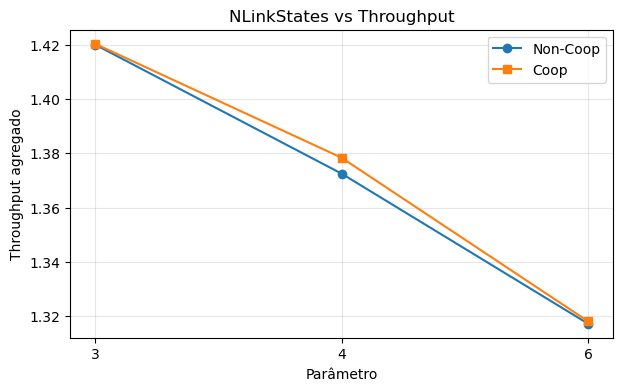

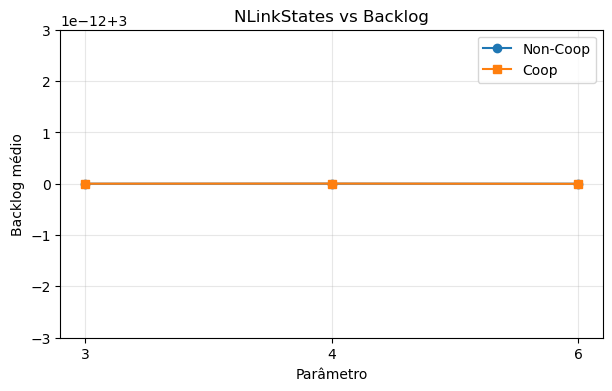

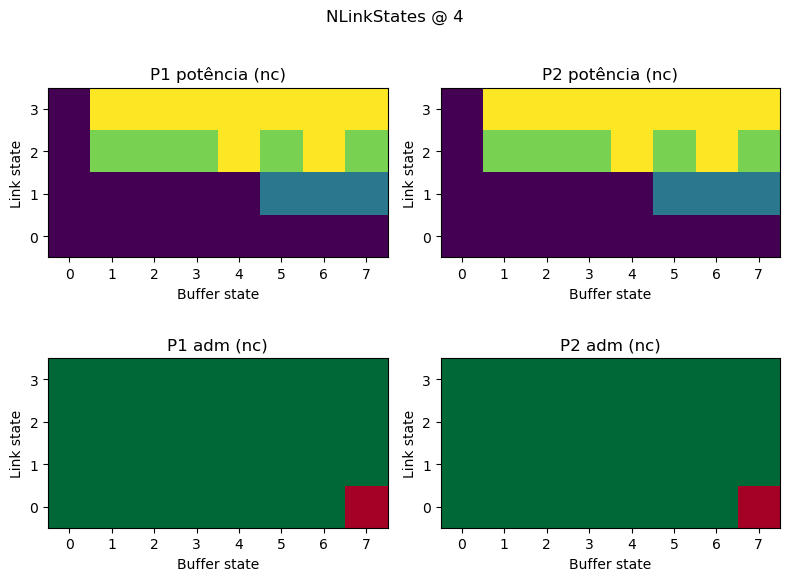

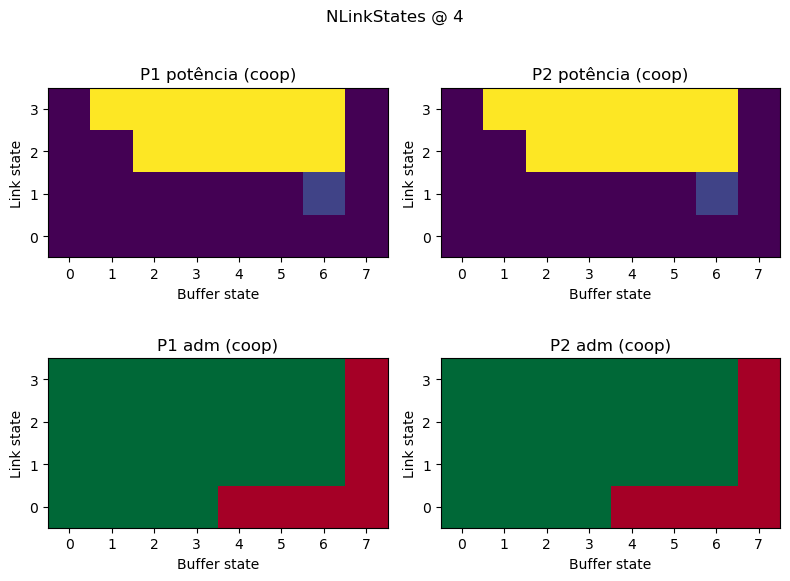

In [38]:

### Variação 3: Número de Estados de Canal (NLinkStates)

base_kwargs = dict(NLinkStates=4, NBufferStates=8, NPowActs=6, NAdmContrActs=2,
                   ArrProb=0.5, v1=2.0, v2=2.0)

link_values = [3, 4, 6]
res_links = run_sweep('NLinkStates', link_values, base_kwargs)

for v in link_values:
    print(f"NLinkStates={v}: NC tput={res_links[v]['nc']['tput']:.4f}, backlog={res_links[v]['nc']['backlog_avg']:.3f} | "
          f"COOP tput={res_links[v]['coop']['tput']:.4f}, backlog={res_links[v]['coop']['backlog_avg']:.3f}")

plot_metric(link_values, res_links, 'tput', 'Throughput agregado', 'NLinkStates vs Throughput')
plot_metric(link_values, res_links, 'backlog_avg', 'Backlog médio', 'NLinkStates vs Backlog')

plot_policies_for(4, res_links, 'NLinkStates')


[Init] Using policy-based equilibrium guess.
[Player 1] val=0.352702, power=2.000000, backlog=2.873 (limit=3.000)
[Player 2] val=0.352654, power=2.000000, backlog=2.873 (limit=3.000)
[Iter 1] val1=0.352702, val2=0.352654, Δ1=3.527e-01, Δ2=3.527e-01
[Player 1] val=0.352654, power=2.000000, backlog=2.873 (limit=3.000)
[Player 2] val=0.352654, power=2.000000, backlog=2.873 (limit=3.000)
[Iter 2] val1=0.352654, val2=0.352654, Δ1=4.792e-05, Δ2=0.000e+00
[Player 1] val=0.352654, power=2.000000, backlog=2.873 (limit=3.000)
[Player 2] val=0.352654, power=2.000000, backlog=2.873 (limit=3.000)
[Iter 3] val1=0.352654, val2=0.352654, Δ1=0.000e+00, Δ2=0.000e+00
[Init] Using policy-based equilibrium guess.
[Player 1] val=0.573009, power=2.000000, backlog=2.998 (limit=3.000)
[Player 2] val=0.611869, power=2.000000, backlog=2.949 (limit=3.000)
[Iter 1] val1=0.573009, val2=0.611869, Δ1=5.730e-01, Δ2=6.119e-01
[Player 1] val=0.612833, power=2.000000, backlog=2.949 (limit=3.000)
[Player 2] val=0.612833, 

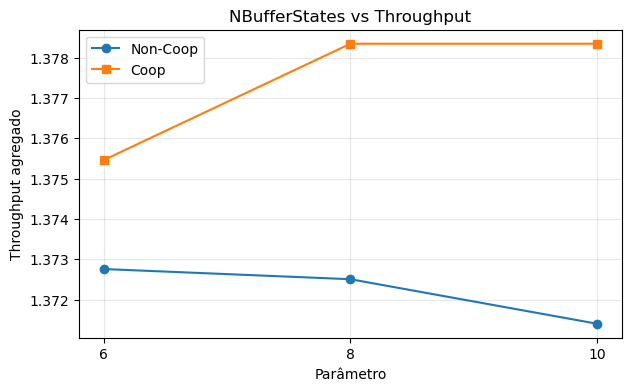

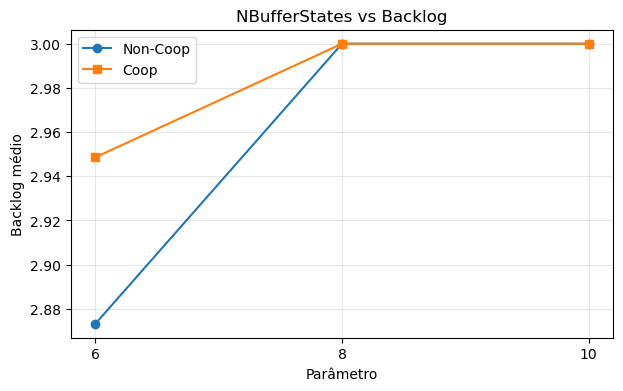

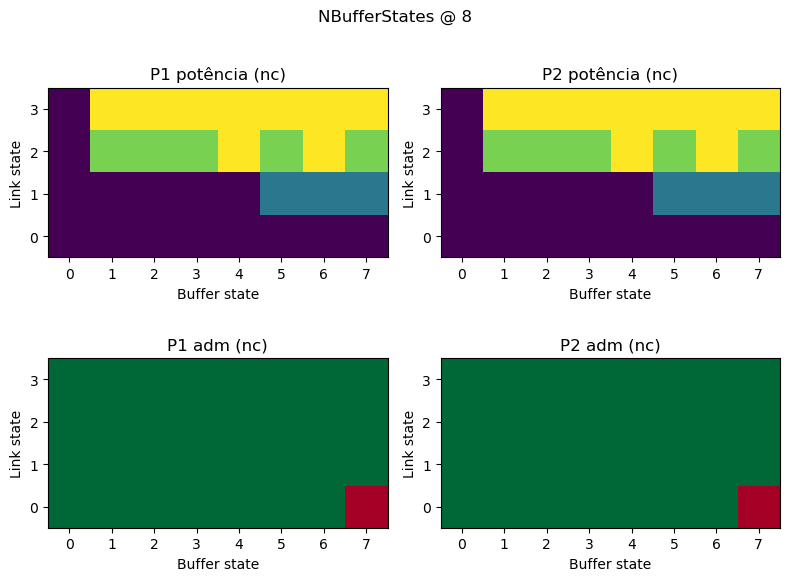

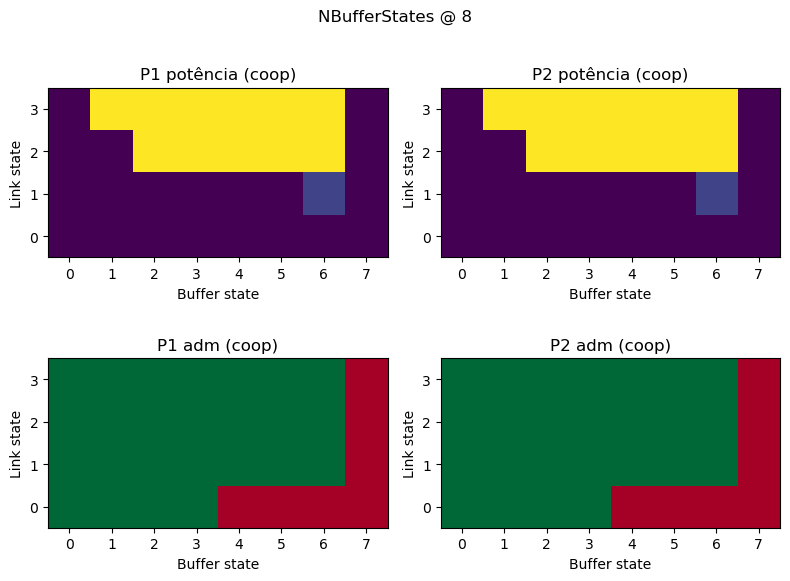

In [39]:

### Variação 4: Tamanho do Buffer (NBufferStates)

base_kwargs = dict(NLinkStates=4, NBufferStates=8, NPowActs=6, NAdmContrActs=2,
                   ArrProb=0.5, v1=2.0, v2=2.0)

buffer_values = [6, 8, 10]
res_buf = run_sweep('NBufferStates', buffer_values, base_kwargs)

for v in buffer_values:
    print(f"NBufferStates={v}: NC tput={res_buf[v]['nc']['tput']:.4f}, backlog={res_buf[v]['nc']['backlog_avg']:.3f} | "
          f"COOP tput={res_buf[v]['coop']['tput']:.4f}, backlog={res_buf[v]['coop']['backlog_avg']:.3f}")

plot_metric(buffer_values, res_buf, 'tput', 'Throughput agregado', 'NBufferStates vs Throughput')
plot_metric(buffer_values, res_buf, 'backlog_avg', 'Backlog médio', 'NBufferStates vs Backlog')

plot_policies_for(8, res_buf, 'NBufferStates')



### Análise da Parte 4 (paramétrica)

**ArrProb:** 0.3 → 0.5 → 0.7 aumenta throughput (1.1114 → 1.3725 → 1.4237) enquanto o backlog fica preso em ~2.8–3.0 pelo Bmax=3. Coop traz ganho modesto (~+0.006 a +0.019) e rejeita um pouco menos em canais ruins.

**Limite de potência (v1=v2):** throughput sobe (1.2071 → 1.3725 → 1.4734) com backlog travado em 3.0; coop rende ~+0.008–0.01 sobre NC.

**NLinkStates:** aumentar estados de canal aqui **reduz** throughput (1.4200 @3 → 1.3725 @4 → 1.3181 @6), backlog segue 3.0. A maior granularidade não trouxe ganho com o Bmax/potência atuais; coop melhora apenas milésimos.

**NBufferStates:** backlog só cai em 6 (2.873); para 8/10 fica ≈3.0. Throughput varia pouco (≈1.372–1.379); coop ligeiramente melhor. Como o limite é sobre backlog médio, aumentar buffer traz pouca folga.

**Resumo geral:** com Bmax=3.0 ativo, o backlog quase sempre satura; ganhos vêm sobretudo de ArrProb e potência. Coop é consistentemente melhor que NC, mas o ganho é pequeno porque a restrição de backlog limita agressividade. Para explorar mais diferenças, seria preciso relaxar Bmax ou variar custos de potência/interferência.
